In [1]:
import dask
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import glob
import folium
import plotly.express as px
from dask.diagnostics import ProgressBar 
from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

In [2]:
data=dd.read_csv('Crimes_-_2001_to_Present.csv',error_bad_lines=False,assume_missing=True,dtype={'ID': np.int64,'PrimaryType': 'str','FBI Code': 'object','Beat': np.uint16,'IUCR': 'str','Latitude': 'object',
'Y Coordinate': 'object','Location': 'str'},  parse_dates=['Date'],infer_datetime_format=True)

In [3]:
data

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
npartitions=29,,,,,,,,,,,,,,,,,,,,,,
,int64,object,datetime64[ns],object,object,object,object,object,bool,bool,uint16,float64,float64,float64,object,float64,object,float64,object,object,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
data.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917,2015.0,02/10/2018 03:50:01 PM,41.815117282,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869,2015.0,02/10/2018 03:50:01 PM,41.895080471,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,2018-09-01 00:01:00,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018.0,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384,2015.0,02/10/2018 03:50:01 PM,41.937405765,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086,2015.0,02/10/2018 03:50:01 PM,41.881903443,-87.755121,"(41.881903443, -87.755121152)"


In [5]:
data.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                            uint16
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                    object
Year                           float64
Updated On                      object
Latitude                        object
Longitude                      float64
Location                        object
dtype: object

## Data Cleaning

#### Dropping columns which are not useful for the analysis

In [6]:
col_drop = ['ID','Case Number','IUCR','X Coordinate','Y Coordinate','Updated On','Location' ]
df= data.drop(col_drop, axis=1)

In [7]:
df.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
0,2015-09-05 13:30:00,043XX S WOOD ST,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015.0,41.815117282,-87.670000
1,2015-09-04 11:30:00,008XX N CENTRAL AVE,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015.0,41.895080471,-87.765400
2,2018-09-01 00:01:00,082XX S INGLESIDE AVE,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,2018.0,NaN,NaN
3,2015-09-05 12:45:00,035XX W BARRY AVE,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015.0,41.937405765,-87.716650
4,2015-09-05 13:00:00,0000X N LARAMIE AVE,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015.0,41.881903443,-87.755121


In [8]:
df.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'FBI Code', 'Year', 'Latitude', 'Longitude'],
      dtype='object')

### Persist DataFrame in memory:
Persist is important because Dask DataFrame is lazy by default. It is often ideal to load, filter, and shuffle data once and keep this result in memory. Afterwards, each of the several complex queries can be based off of this in-memory data rather than have to repeat the full load-filter-shuffle process each time.

In [9]:
%%time
with ProgressBar(): 
    df = df.persist() # Persist the dataframe in memory

[########################################] | 100% Completed | 16min 37.7s
Wall time: 16min 37s


### Handle missing values

In [10]:
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Arrest    int64
Year        ...
dtype: int64
Dask Name: dataframe-sum-agg, 88 tasks

In [11]:
missing_count = ((missing_values / df.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Arrest    float64
Year          ...
dtype: float64
Dask Name: mul, 149 tasks

In [12]:
%%time
with ProgressBar(): 
    missing_count_pc = missing_count.compute()
missing_count_pc

[########################################] | 100% Completed |  1.4s
Wall time: 1.35 s


Date                    0.000000
Block                   0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.129889
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000608
Ward                    7.949618
Community Area          7.931892
FBI Code                0.000000
Year                    0.000000
Latitude                1.095420
Longitude               1.095420
dtype: float64

### Drop rows with missing values

The percentage of missing data in each column is extremely low (less than 10%), Dropping the missing data instead of updating which is very expensive operation.

In [13]:
%%time
rows_to_drop = list(missing_count_pc[(missing_count_pc > 0) & (missing_count_pc < 10)].index)
df = df.dropna(subset=rows_to_drop)   

Wall time: 11.3 ms


### Check after dropping missing

In [14]:
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Arrest    int64
Year        ...
dtype: int64
Dask Name: dataframe-sum-agg, 117 tasks

In [15]:
missing_count = ((missing_values / df.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Arrest    float64
Year          ...
dtype: float64
Dask Name: mul, 178 tasks

In [16]:
%%time
with ProgressBar(): 
    missing_count_pc = missing_count.compute()
missing_count_pc

[########################################] | 100% Completed |  2.6s
Wall time: 2.58 s


Date                    0.0
Block                   0.0
Primary Type            0.0
Description             0.0
Location Description    0.0
Arrest                  0.0
Domestic                0.0
Beat                    0.0
District                0.0
Ward                    0.0
Community Area          0.0
FBI Code                0.0
Year                    0.0
Latitude                0.0
Longitude               0.0
dtype: float64

### Duplicates

In [17]:
%%time
df = df.drop_duplicates()

Wall time: 12.1 ms


#### Set Date as index

In [18]:
%%time
with ProgressBar():
    df = df.set_index('Date') 

[########################################] | 100% Completed | 18.2s
Wall time: 18.2 s


In [19]:
%%time
df.compute().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7018935 entries, 2001-01-01 00:00:00 to 2023-02-07 23:55:00
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Block                 object 
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  uint16 
 7   District              float64
 8   Ward                  float64
 9   Community Area        float64
 10  FBI Code              object 
 11  Year                  float64
 12  Latitude              object 
 13  Longitude             float64
dtypes: bool(2), float64(5), object(6), uint16(1)
memory usage: 669.4+ MB
Wall time: 19.1 s


In [61]:
df.head()

,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
Date,,,,,,,,,,,,,,
2001-01-01,113XX S STEWART AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,2001.0,41.687650803,-87.632719
2001-01-01,076XX S MAY ST,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,612,6.0,17.0,71.0,02,2001.0,41.755090605,-87.652502
2001-01-01,044XX S CALIFORNIA AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,912,9.0,12.0,58.0,06,2001.0,41.812451386,-87.694479
2001-01-01,057XX N RIDGE AVE,CRIM SEXUAL ASSAULT,PREDATORY,APARTMENT,False,True,2013,20.0,48.0,77.0,02,2001.0,41.986229998,-87.664563
2001-01-01,022XX W 80TH ST,THEFT,AGG: FINANCIAL ID THEFT,OTHER,False,False,835,8.0,18.0,70.0,06,2001.0,41.748448075,-87.679203


### Top 10 Years with highest crime records

In [21]:
crime_by_year=df.groupby([df.index.year]).size().compute()
        
top_10_years = crime_by_year.nlargest(10).sort_values(axis=0,ascending=False)
top_10_years

Date
2003    469887
2004    465241
2005    448194
2006    443508
2007    434163
2008    418954
2009    385193
2010    369187
2011    350347
2002    343893
dtype: int64

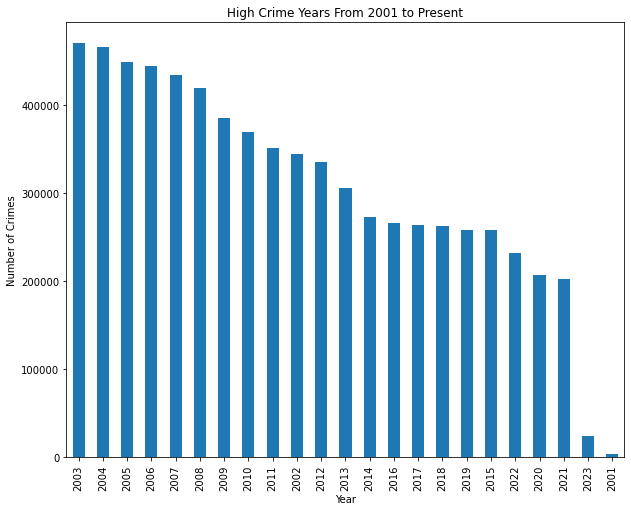

In [22]:
crime_by_year.sort_values(axis=0,ascending=False).plot(kind='bar', figsize=(10,8))
plt.title('High Crime Years From 2001 to Present')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

**2001 has the lowest number of crime where 2003 has the highest number of crime.**

In [23]:
community_crime = df.groupby('Community Area').size().compute()
community_crime.nlargest(10).sort_values(axis=0,ascending=False)

Community Area
25.0    439701
8.0     246517
43.0    232289
23.0    219270
28.0    211400
24.0    205436
29.0    204378
67.0    201769
71.0    199607
49.0    187194
dtype: int64

**here the coummunity areas are identified with the number. the community area data has been downloaded from the website to get the name of the areas.**

In [30]:
# upload the community file
community_area = pd.read_csv('CommAreas.csv')
# apply groupby function and calculate the amount of crime, rename to crime_num
community_area['crime_num'] = df.groupby('Community Area').size().compute().rename('crime_num')
community_area = community_area.set_index('COMMUNITY')
community_area=community_area.drop(['the_geom','PERIMETER','AREA','COMAREA_','COMAREA_ID','AREA_NUMBE','AREA_NUM_1','SHAPE_AREA','SHAPE_LEN'], axis=1)
community_area.head(5)

,crime_num
COMMUNITY,
DOUGLAS,67
OAKLAND,108218
FULLER PARK,89792
GRAND BOULEVARD,102616
KENWOOD,50148


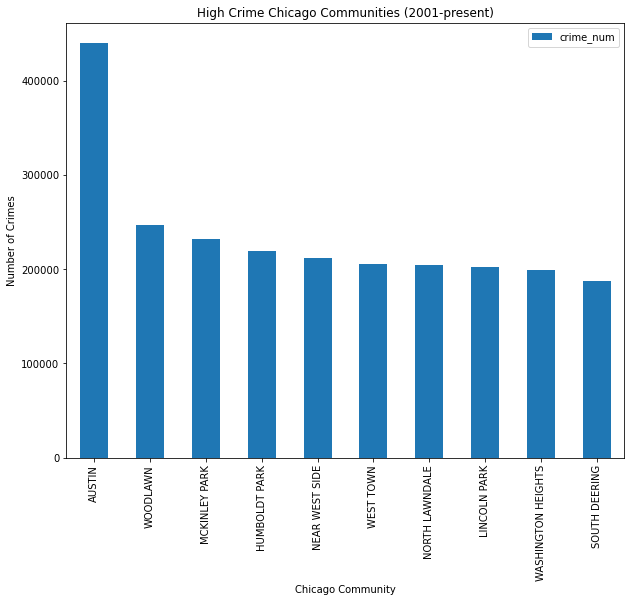

In [31]:
# top 10 of most violent community area
community_area.nlargest(10,'crime_num').plot(kind='bar', figsize=(10,8))
plt.title('High Crime Chicago Communities (2001-present)')
plt.xlabel('Chicago Community')
plt.ylabel('Number of Crimes')
plt.show()

#### Count of Arrest, domestic and total crimes group by crime types

In [34]:
# get crime types
crime_types = df[['Primary Type']]

# get crime counts by primary type
crime_type_total =df.groupby('Primary Type').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = df[['Primary Type', 'Arrest', 'Domestic']].groupby('Primary Type').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crimes (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                     Arrest  Domestic    Total
Primary Type                                                  
THEFT                              162578.0   41032.0  1486598
BATTERY                            284373.0  573793.0  1290848
CRIMINAL DAMAGE                     53241.0   69493.0   804034
NARCOTICS                          657203.0     286.0   661327
ASSAULT                             97879.0  105634.0   461359
OTHER OFFENSE                       76795.0  132396.0   436442
BURGLARY                            21901.0    3449.0   388071
MOTOR VEHICLE THEFT                 26269.0    2157.0   333545
DECEPTIVE PRACTICE                  39583.0    3380.0   299092
ROBBERY                             24770.0    4355.0   266350
CRIMINAL TRESPASS                  135706.0    7038.0   194796
WEAPONS VIOLATION                   73032.0     355.0    98670
PROSTITUTION                        59993.0       7.0    60250
OFFENSE INVOLVING CHILDREN           9250.0   26732.0  

#### visualization of  crimes by primary type counts

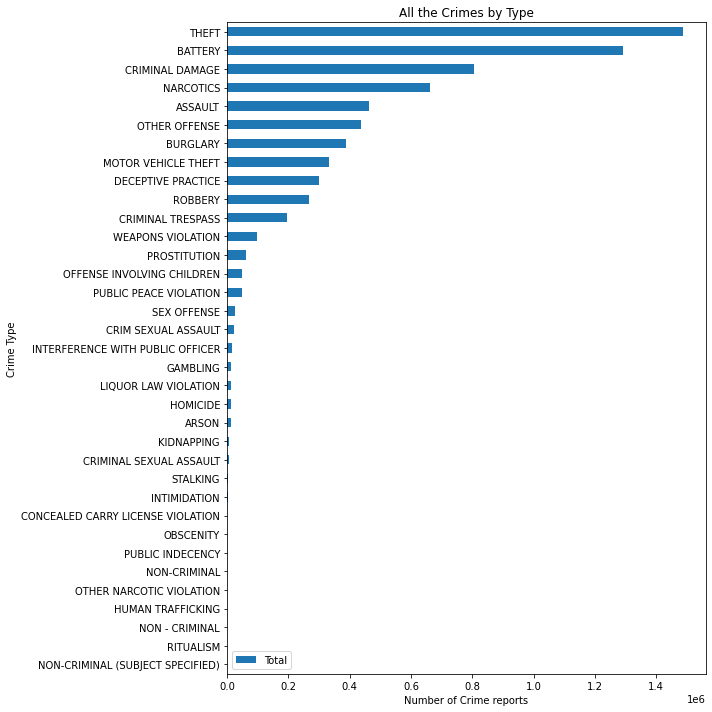

In [41]:
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True).drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(10,10))
plt.title('All the Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

**Theft is the most common crime type in Chicago.**

###  Top 10 types of crimes and their number of occurences

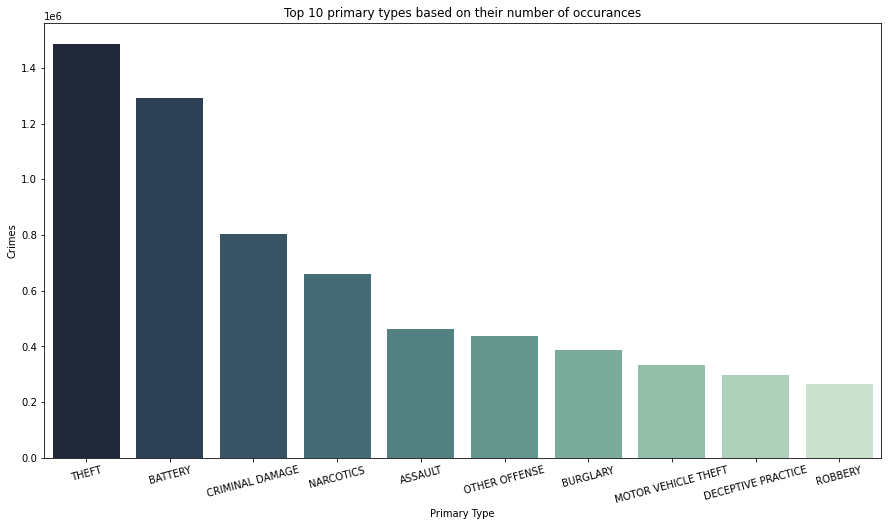

In [43]:
Crime_Type = df["Primary Type"]
Prim_Type_Countr = Counter(Crime_Type)
Top_Crime_Type = Prim_Type_Countr.most_common(10)
x,y = zip(*Top_Crime_Type)
x,y  = list(x),list(y)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=x, y=y, palette = sns.cubehelix_palette(len(x), rot=-.4, reverse=True))
plt.xticks(rotation= 15)
plt.title("Top 10 primary types based on their number of occurances")
plt.xlabel("Primary Type")
plt.ylabel("Crimes")
plt.show()

### Details about Crime: Theft

In [44]:
Theft = df[df['Primary Type']== "THEFT"]
Theft_details = Theft[['Primary Type', 'Description']].groupby('Description').count().compute().sort_values(by='Primary Type', ascending=False)
Theft_details.head()

,Primary Type
Description,
$500 AND UNDER,544649
OVER $500,364618
FROM BUILDING,250026
RETAIL THEFT,200311
POCKET-PICKING,38660


**Most of the theft reported cases are '$500 and under' description.**

### Top Crimes (>= 200,000 reports)

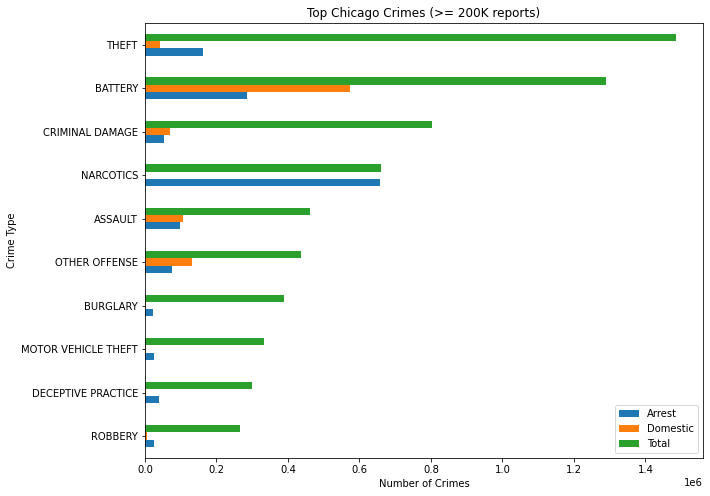

In [45]:
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.show()

### Top 10 locations by no. of crimes (Based on Location Description)

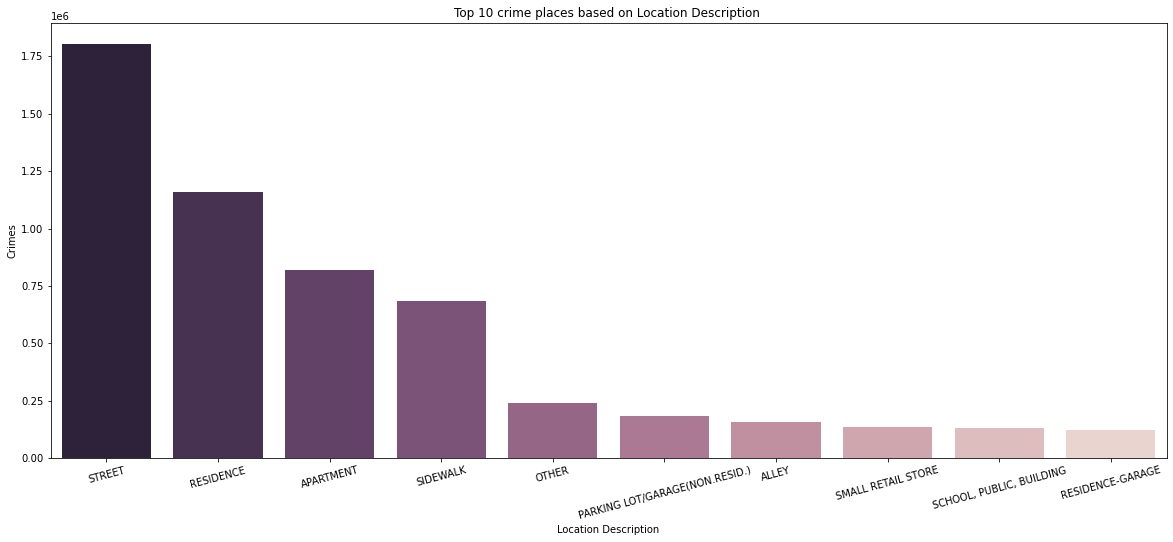

In [46]:
location = df["Location Description"]
counted_loc = Counter(location) 
top_location = counted_loc.most_common(10)
x,y = zip(*top_location)
x,y = list(x),list(y)
plt.figure(figsize = (20,8))
ax = sns.barplot(x = x , y = y, palette = sns.cubehelix_palette(len(x), reverse=True))
plt.xticks(rotation= 15)
plt.xlabel("Location Description")
plt.ylabel("Crimes")
plt.title("Top 10 crime places based on Location Description ")
plt.show()

**The most common crime location is Chicago streets.**

### 'Other Offenses'

In [47]:
other_offenses = df[df['Primary Type']=='OTHER OFFENSE']
other_offense_crime = other_offenses[['Primary Type', 'Description']].groupby('Description').count().compute().sort_values(by='Primary Type', ascending=False)
other_offense_crime.head(10)

,Primary Type
Description,
TELEPHONE THREAT,135578
HARASSMENT BY TELEPHONE,98164
VIOLATE ORDER OF PROTECTION,36822
OTHER VEHICLE OFFENSE,35828
HARASSMENT BY ELECTRONIC MEANS,33290
FALSE/STOLEN/ALTERED TRP,21743
OTHER CRIME INVOLVING PROPERTY,8827
VEHICLE TITLE/REG OFFENSE,8465
LICENSE VIOLATION,7981


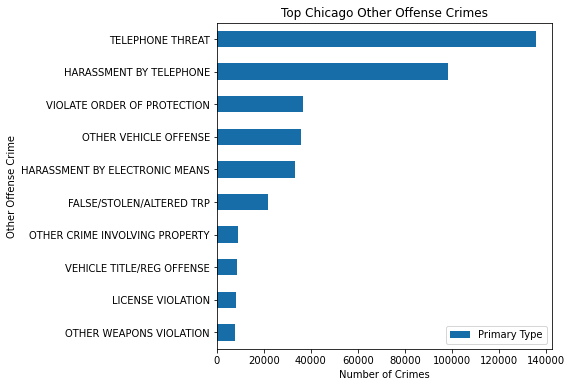

In [48]:
other_offense_crime[:10].sort_values(by='Primary Type', ascending=True).plot(kind='barh', figsize=(6,6), color='#166DA7')
plt.title('Top Chicago Other Offense Crimes')
plt.xlabel('Number of Crimes')
plt.ylabel('Other Offense Crime')
plt.show()

### Comparing Arrested or Not

In [51]:
Arrest= Counter(df["Arrest"]).most_common()
x,y = zip(*Arrest)
x,y = list(x),list(y)
x,y

([False, True], [5200886, 1818049])

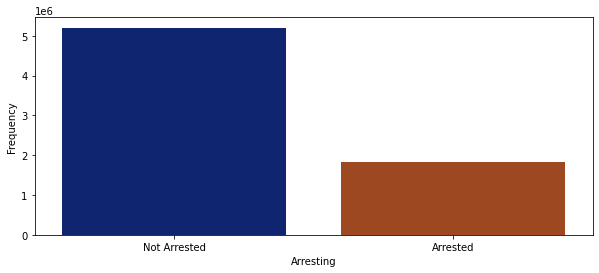

In [52]:
x[1] = "Arrested"
x[0] = "Not Arrested" 
plt.figure(figsize=(10,4))
sns.barplot(x = x , y = y , palette = "dark")
plt.xlabel("Arresting")
plt.ylabel("Frequency")
plt.show()

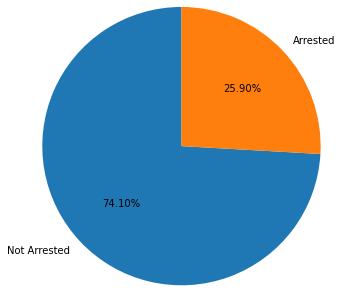

In [53]:
plt.pie(y,
        labels = x, 
        autopct = "%0.2f%%", # Show data in percentage with 2 decimal point
        startangle = 90,
        radius = 1.6
         )
plt.show()

### Arrested Rate Per Crime

In [63]:
arrest_rate = df.groupby('Primary Type')['Arrest'].mean().reset_index()
arrest_rate['Arrest (%)'] = arrest_rate['Arrest'].round(4)*100
arrest_rate.head(10)

,Primary Type,Arrest,Arrest (%)
0,ARSON,0.119433,11.94
1,ASSAULT,0.212154,21.22
2,BATTERY,0.220299,22.03
3,BURGLARY,0.056436,5.64
4,CONCEALED CARRY LICENSE VIOLATION,0.962209,96.22
5,CRIM SEXUAL ASSAULT,0.150126,15.01
6,CRIMINAL DAMAGE,0.066217,6.62
7,CRIMINAL SEXUAL ASSAULT,0.068019,6.80
8,CRIMINAL TRESPASS,0.696657,69.67
9,DECEPTIVE PRACTICE,0.132344,13.23


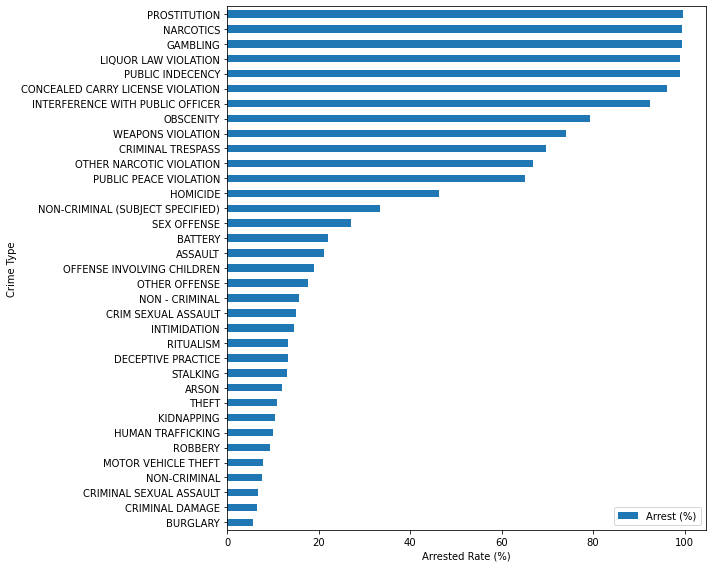

In [64]:
arrest_rate = arrest_rate.compute()
arrest_rate = arrest_rate.sort_values(by='Arrest (%)', ascending=True).drop(['Arrest'], axis=1) # denotes column
arrest_rate.plot(x="Primary Type", y="Arrest (%)", kind='barh', figsize=(10,8))
plt.xlabel('Arrested Rate (%)')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

**Prostitution, narcotics, gambling, liquor law viloation, public indecency are the crimes for which most of the arresting occurs.**

### Visualization of crimes per day of the week

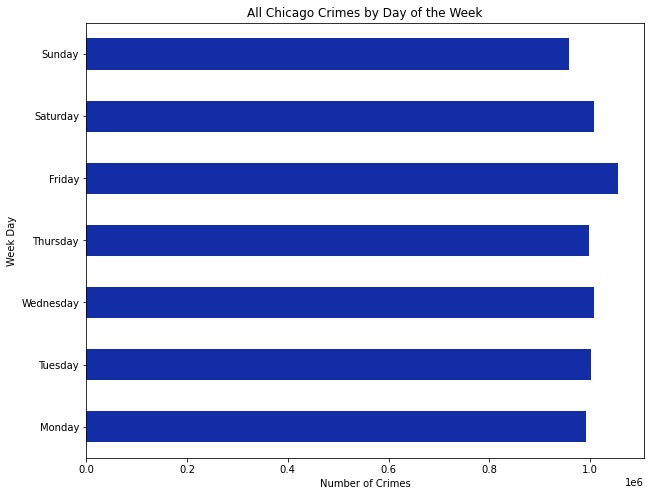

In [69]:

days = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_crime = df.groupby([df.index.dayofweek]).size()
df_crime.plot(kind='barh', figsize=(10,8), color='#132DA6')
plt.title('All Chicago Crimes by Day of the Week')
plt.xlabel('Number of Crimes')
plt.ylabel('Week Day')
plt.yticks(np.arange(7), days)
plt.show()

**The highest criminal activites occured on fridays.**

### Visualization of crimes per month of the year

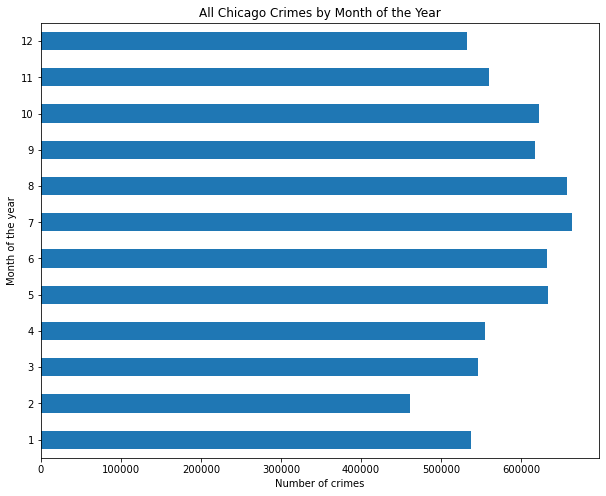

In [70]:
df.groupby([df.index.month]).size().plot(kind='barh', figsize=(10,8))
plt.title('All Chicago Crimes by Month of the Year')
plt.xlabel('Number of crimes')
plt.ylabel('Month of the year')
plt.show()

**The peak of the crimes is during summer(July) across all these years.**

### Sum of all crimes through the years

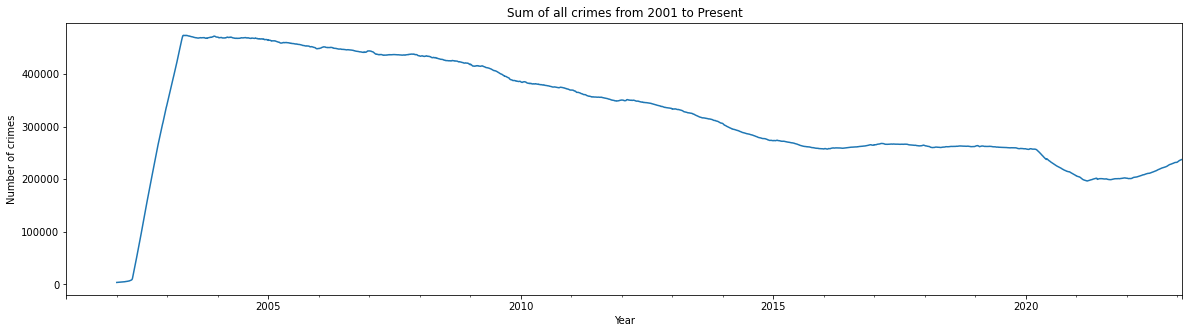

In [73]:
plt.figure(figsize=(20,5))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Sum of all crimes from 2001 to Present')
plt.ylabel('Number of crimes')
plt.xlabel('Year')
plt.show()

**Number of crimes reported has declined gradually over the years.**

### Mapping Theft Crime Locations

In [75]:
Thft = df.drop(columns=['Block', 'Domestic', 'Beat', 'District', 'Ward', 'FBI Code'], axis = 1)
Thft = Thft[Thft["Primary Type"] == "THEFT"]
Thft.head()

,Primary Type,Description,Location Description,Arrest,Community Area,Year,Latitude,Longitude
Date,,,,,,,,
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,49.0,2001.0,41.687650803,-87.632719
2001-01-01,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,58.0,2001.0,41.812451386,-87.694479
2001-01-01,THEFT,AGG: FINANCIAL ID THEFT,OTHER,False,70.0,2001.0,41.748448075,-87.679203
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,22.0,2001.0,41.916126623,-87.718107
2001-01-01,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,23.0,2001.0,41.910524926,-87.733533


In [76]:
locations = Thft.groupby('Community Area').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude']]
new_locations.head()

,Latitude,Longitude
Community Area,,
0.0,41.799089601,-87.790549
1.0,42.015277064,-87.683162
2.0,41.99876544,-87.683672
3.0,41.972573024,-87.652114
4.0,41.962879197,-87.675896


In [78]:
Chicago_crime = folium.Map(location=[41.881832, -87.623177], zoom_start=11)
i=0
for index, row in new_locations.iterrows():
    folium.Marker(location = [row['Latitude'], row['Longitude']]).add_to(Chicago_crime)

Chicago_crime

### Overall number of cases per Year x Months using Heatmap

In [79]:
df2 = pd.DataFrame(df.resample("M").size(), columns=["Number of cases"])
df2["Month"] = df2.index.month.astype(str)
df2["Year"] = df2.index.year.astype(str)
df2["Year-Month"] = df2["Year"].str.cat(df2["Month"].str.zfill(2), sep="-")
df2.head()

,Number of cases,Month,Year,Year-Month
Date,,,,
2001-01-31,406,1,2001,2001-01
2001-02-28,164,2,2001,2001-02
2001-03-31,193,3,2001,2001-03
2001-04-30,245,4,2001,2001-04
2001-05-31,229,5,2001,2001-05


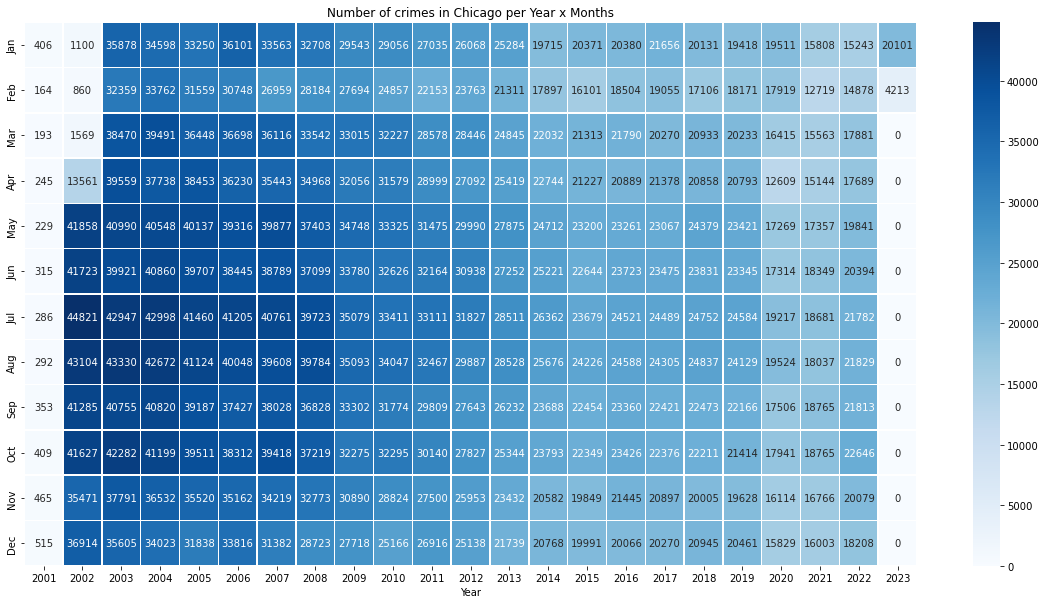

In [80]:
df3 = df2[["Month", "Year", "Number of cases"]]
df3 = df3.pivot("Month", "Year", "Number of cases").fillna(0).astype(int)
df3.index = df3.index.astype(int)
df3 = df3.sort_index()
df3.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(20, 10))
_ = sns.heatmap(
    df3,
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Blues",
).set_title('Number of crimes in Chicago per Year x Months')

**The years between 2002 and 2008 have a darker blue colour which means the crime rate was high that time.**